In [134]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate
import pyfits
import plotc
import read_params
import matplotlib.pyplot as plt
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil
%matplotlib

Using matplotlib backend: Qt4Agg


In [2]:
Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun=695.8
z,c_sound = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1],unpack=True); z=(z-1)*Rsun;c_sound/=100;

psi_true = np.squeeze(pyfits.getdata(read_params.get_true_psi_filename()))
vx_true = np.squeeze(pyfits.getdata(read_params.get_true_vx_filename()))
vz_true = np.squeeze(pyfits.getdata(read_params.get_true_vz_filename()))
nz_max,nx_max = np.unravel_index(psi_true.argmax(),psi_true.shape)

gl = plotc.gridlist(1,3)
plotc.colorplot(psi_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl),title="psi",centerzero=True);
plotc.colorplot(vx_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl),title="vx",centerzero=True);
plotc.colorplot(vz_true,x=x,y=z,yr=[-5,None],xr=[-50,50],sp=next(gl),title="vz",centerzero=True);
plt.tight_layout()

### Duvall-Hanasoge model

In [97]:
kDH13 = 2*np.pi/30
RDH13 = 15
sigmazDH13 = 0.912
z0DH13 = -2.3
v0DH13 = 240

## Spline only along z

In [6]:
z_cutoff = -6 # Spline lower cutoff
zspline_ind = z>z_cutoff
zspline = z[zspline_ind]

psi_spline = psi_true[zspline_ind,nx_max]

In [40]:
tz1D,cz1D,kz=interpolate.splrep(zspline.flatten(),psi_spline.flatten(),k=2,s=1e-6)
print(tz1D.shape,cz1D.shape)

(15,) (15,)


In [56]:
psi_spl_fit=interpolate.splev(z[zspline_ind],(tz1D,cz1D,kz));
plt.plot(zspline,psi_spline,linewidth=2,color="darkgreen");
plt.plot(zspline,psi_spl_fit,'o',markersize=5,color="orange");

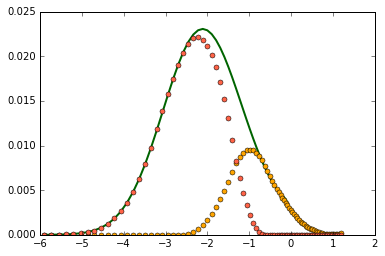

In [45]:
c_surf_cutoff=6
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]

psi_spl_fit_top=interpolate.splev(z[zspline_ind],(tz1D,cz1D_top,kz));
plt.plot(zspline,psi_spline,linewidth=2,color="darkgreen");
plt.plot(zspline,psi_spl_fit_top,'o',markersize=5,color="orange");

cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]
psi_spl_fit_bottom=interpolate.splev(z[zspline_ind],(tz1D,cz1D_bottom,kz));
plt.plot(zspline,psi_spl_fit_bottom,'o',markersize=5,color="tomato");

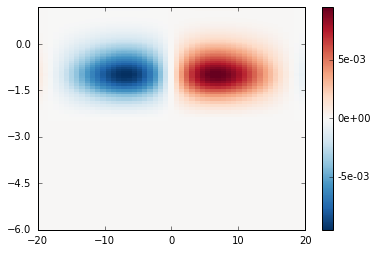

In [51]:
psi_z_start=np.zeros(z.size)
psi_z_start[zspline_ind] = psi_spl_fit_top
psi_z_start=psi_z_start[:,None]

psi_xpart = np.sign(x[None,:])*j1(kDH13*abs(x[None,:]))*np.exp(-abs(x[None,:])/RDH13)
psi_xpart /= psi_xpart.max()
psi_spl_fit_fullsize = psi_xpart*psi_z_start

plotc.colorplot(psi_spl_fit_fullsize,x=x,y=z,xr=[-20,20],yr=[z_cutoff,None]);

In [53]:
import read_params
import warnings
datadir = read_params.get_directory()
model_back = psi_true.max()/1.04
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00.fits"),
                   psi_spl_fit_fullsize[:,np.newaxis,:]+model_back,clobber=True)
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00_start.fits"),
                   psi_spl_fit_fullsize[:,np.newaxis,:]+model_back,clobber=True)
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),back=model_back,c_lower=np.zeros_like(cz1D))
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"),back=model_back,c_lower=np.zeros_like(cz1D))
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),tz=tz1D,kz=kz,
        c_upper=cz1D_top,c_lower=cz1D_bottom,coeff_surf_cutoff_ind=c_surf_cutoff,z_cutoff = z_cutoff)

## Splines in 2D: 2 independent splines

### z spline

In [138]:
z_cutoff = -6 # Spline lower cutoff
zspline_ind = z>z_cutoff
zspline = z[zspline_ind]

psi_spline_z = psi_true[zspline_ind,nx_max]
# psi_max = psi_spline_z.max()
# psi_spline_z/=np.sqrt(psi_max)

In [139]:
tz1D,cz1D,kz=interpolate.splrep(zspline.flatten(),psi_spline_z.flatten(),k=2,s=1e-6)
print("Number of knots:",tz1D.size)
print("Number of coeffs:",tz1D.size-kz-1)
print("Number of extra zero coeffs at end, should be {:d}, is {:d}".format(
        cz1D.size-(tz1D.size-kz-1),np.where(cz1D==0)[0].size))

Number of knots: 15
Number of coeffs: 12
Number of extra zero coeffs at end, should be 3, is 3


### Determine the coefficient that corresponds to the surface

In [140]:
b_i_surf = np.zeros_like(cz1D)
for i in xrange(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i_surf[i] = interpolate.splev(0,(tz1D,c_i,kz))

c_surf_cutoff = b_i_surf.argmax()
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]
print("{:d} parameters to  be fit along z, {:d} parameters clamped, "
      "{:d} redundant parameters at the end".format(c_surf_cutoff,
                                            (tz1D.size-kz-1) - c_surf_cutoff,
                                            cz1D.size-(tz1D.size-kz-1)))
print("Coeffs below surface",cz1D[:c_surf_cutoff])
print("Median of coeffs below surface : {:.2E}, stdev: {:.2E}".format(np.median(cz1D[:c_surf_cutoff]),
                                                                     np.std(cz1D[:c_surf_cutoff])))

9 parameters to  be fit along z, 3 parameters clamped, 3 redundant parameters at the end
Coeffs below surface [  1.10488117e-05  -2.17593837e-05   4.83868442e-04   4.94600736e-03
   1.69089175e-02   2.66398153e-02   1.16975237e-02   5.99669143e-03
   4.08322419e-03]
Median of coeffs below surface : 4.95E-03, stdev: 8.52E-03


### Depth cuts through z spline

In [188]:
psi_spl_fit_top=interpolate.splev(z[zspline_ind],(tz1D,cz1D_top,kz));
plt.plot(zspline,psi_spline_z,linewidth=2,color="darkgreen");
plt.plot(zspline,psi_spl_fit_top,'o',markersize=5,color="orange");

psi_spl_fit_bottom=interpolate.splev(z[zspline_ind],(tz1D,cz1D_bottom,kz));
plt.plot(zspline,psi_spl_fit_bottom,'o',markersize=5,color="tomato");

### Spline fit to horizontal wavelength

In [182]:
wavelength_depths = np.array([-5,-4,-2,-0.5,0]);
tR,cR,kR = interpolate.splrep(wavelength_depths,np.zeros_like(wavelength_depths),k=2)
tR,cR,kR = interpolate.insert(-0.5,(tR,cR,kR),m=2)
print("Number of spline coefficients:",tR.size-kR-1)
print(tR)
print(cR)
R_surf_cutoff = -6

Number of spline coefficients: 7
[-5.   -5.   -5.   -3.   -1.25 -0.5  -0.5   0.    0.    0.  ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### Model from x and z coefficients

In [191]:
def coeff_to_model(tck_R,tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    f0_x_max = f0_x.max()
    # f1_x is the derivative of f0_x wrt R
    f1_x = x*np.exp(-abs(x)/RDH13)/RDH13**2*(j1(kDH13*abs(x))-np.pi*j1prime(kDH13*abs(x)))
    f0_x/=f0_x_max
    f1_x/=f0_x_max

    R1_z = interpolate.splev(z,tck_R,ext=1)
    h_z=interpolate.splev(z,tck_z,ext=1)

    return (f0_x[None,:]+f1_x[None,:]*R1_z[:,None])*h_z[:,None]

psi_spline = coeff_to_model((tR,np.zeros_like(tR),kR),(tz1D,cz1D_top+cz1D_bottom,kz))
psi_spline_surf = coeff_to_model((tR,np.zeros_like(tR),kR),(tz1D,cz1D_top,kz))
plotc.colorplot(psi_true,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=131);
plotc.colorplot(psi_spline,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=132);
plotc.colorplot(psi_spline_surf,x=x,y=z,xr=[-70,70],yr=[-7,None],centerzero=True,sp=133);
plt.tight_layout()

### Save Coefficients

In [195]:
import read_params
import warnings
datadir = read_params.get_directory()
print("Saving to",datadir)
model_back = psi_true.max()/1.04
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pyfits.writeto(os.path.join(datadir,"model_psi_ls00.fits"),
                   psi_spline_surf[:,np.newaxis,:]+model_back,clobber=True)
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00.fits"),
                   os.path.join(datadir,"model_psi_ls00_start.fits"))
    np.savez(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
             back=model_back,cz_bot=np.zeros_like(cz1D),cR=np.zeros_like(tR))
    shutil.copyfile(os.path.join(datadir,"model_psi_ls00_coeffs.npz"),
                    os.path.join(datadir,"model_psi_ls00_coeffs_start.npz"))
             
    np.savez(os.path.join(datadir,"true_psi_coeffs.npz"),
         cz_top = cz1D_top,cz_bot = cz1D_bottom,tz=tz1D,kz=kz,
         tR = tR,kR=kR,
         z_spline_cutoff=z_cutoff,c_surf_cutoff=c_surf_cutoff,R_surf_cutoff=R_surf_cutoff )

Saving to /scratch/jishnu/flows/spline_z_R_cg
